# Yoga Pose Classification

### 1.Introduction

### 2.Motivation

### 3.Problem Statement

### 4.Data Sources：

### 5.Dataset Description:

### 6.Challenging Aspects:
The Yoga-82 dataset presents several challenges:


### Method 1: CNN + MobileNetV3

#### 1.1 Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image, ImageFile

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint,TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Model
# from tensorflow.keras.layers import Rescaling, Normalization, RandomFlip, RandomRotation
from tensorflow.keras.layers.experimental import preprocessing

# 检查 GPU 是否可用
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU:", tf.config.list_physical_devices('GPU')[0])
else:
    print("No GPU detected, using CPU instead.")


# System libraries
from pathlib import Path
import os.path
import requests
import sys
import os

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

Num GPUs Available:  1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


#### 1.2 Create Helper Functions

In [2]:
# 设置文件 URL
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

file_path = "helper_functions.py"

# Check if the file already exists
if not os.path.exists(file_path):
    # Send a GET request to fetch the file content
    response = requests.get(url)
    
    # Write the content to the file
    with open(file_path, "wb") as file:
        file.write(response.content)
    
    print("Download complete!")
else:
    print("helper_functions.py already exists locally. Skipping download.")

# Add the current working directory to the Python path
sys.path.append(os.getcwd())

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

helper_functions.py already exists locally. Skipping download.


### 1.3 Load and Transform Data

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# Walk through each directory
dataset = "../yoga_dataset_links"
walk_through_dir(dataset)

There are 82 directories and 0 images in '../yoga_dataset_links'.
There are 0 directories and 84 images in '../yoga_dataset_links\Akarna_Dhanurasana'.
There are 0 directories and 76 images in '../yoga_dataset_links\Bharadvaja's_Twist_pose_or_Bharadvajasana_I_'.
There are 0 directories and 372 images in '../yoga_dataset_links\Boat_Pose_or_Paripurna_Navasana_'.
There are 0 directories and 260 images in '../yoga_dataset_links\Bound_Angle_Pose_or_Baddha_Konasana_'.
There are 0 directories and 216 images in '../yoga_dataset_links\Bow_Pose_or_Dhanurasana_'.
There are 0 directories and 251 images in '../yoga_dataset_links\Bridge_Pose_or_Setu_Bandha_Sarvangasana_'.
There are 0 directories and 307 images in '../yoga_dataset_links\Camel_Pose_or_Ustrasana_'.
There are 0 directories and 404 images in '../yoga_dataset_links\Cat_Cow_Pose_or_Marjaryasana_'.
There are 0 directories and 302 images in '../yoga_dataset_links\Chair_Pose_or_Utkatasana_'.
There are 0 directories and 293 images in '../yoga_d

### 1.4 Placing Data into a Dataframe

In [4]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

image_df

Filepath  \
0      ..\yoga_dataset_links\Akarna_Dhanurasana\0_15.jpg   
1      ..\yoga_dataset_links\Akarna_Dhanurasana\0_162...   
2      ..\yoga_dataset_links\Akarna_Dhanurasana\0_18.jpg   
3      ..\yoga_dataset_links\Akarna_Dhanurasana\0_305...   
4      ..\yoga_dataset_links\Akarna_Dhanurasana\0_377...   
...                                                  ...   
37195  ..\yoga_dataset_links\viparita_virabhadrasana_...   
37196  ..\yoga_dataset_links\viparita_virabhadrasana_...   
37197  ..\yoga_dataset_links\viparita_virabhadrasana_...   
37198  ..\yoga_dataset_links\Cobra_Pose_or_Bhujangasa...   
37199  ..\yoga_dataset_links\Cobra_Pose_or_Bhujangasa...   

                                                 Label  
0                                   Akarna_Dhanurasana  
1                                   Akarna_Dhanurasana  
2                                   Akarna_Dhanurasana  
3                                   Akarna_Dhanurasana  
4                                   Akarna_Dhanurasana  
...                                                ...  
37195  viparita_virabhadrasana_or_reverse_warrior_pose  
37196  viparita_virabhadrasana_or_reverse_warrior_pose  
37197  viparita_virabhadrasana_or_reverse_warrior_pose  
37198                      Cobra_Pose_or_Bhujangasana_  
37199                      Cobra_Pose_or_Bhujangasana_  

[37200 rows x 2 columns]

### 1.5 Visualizing Images from dataset

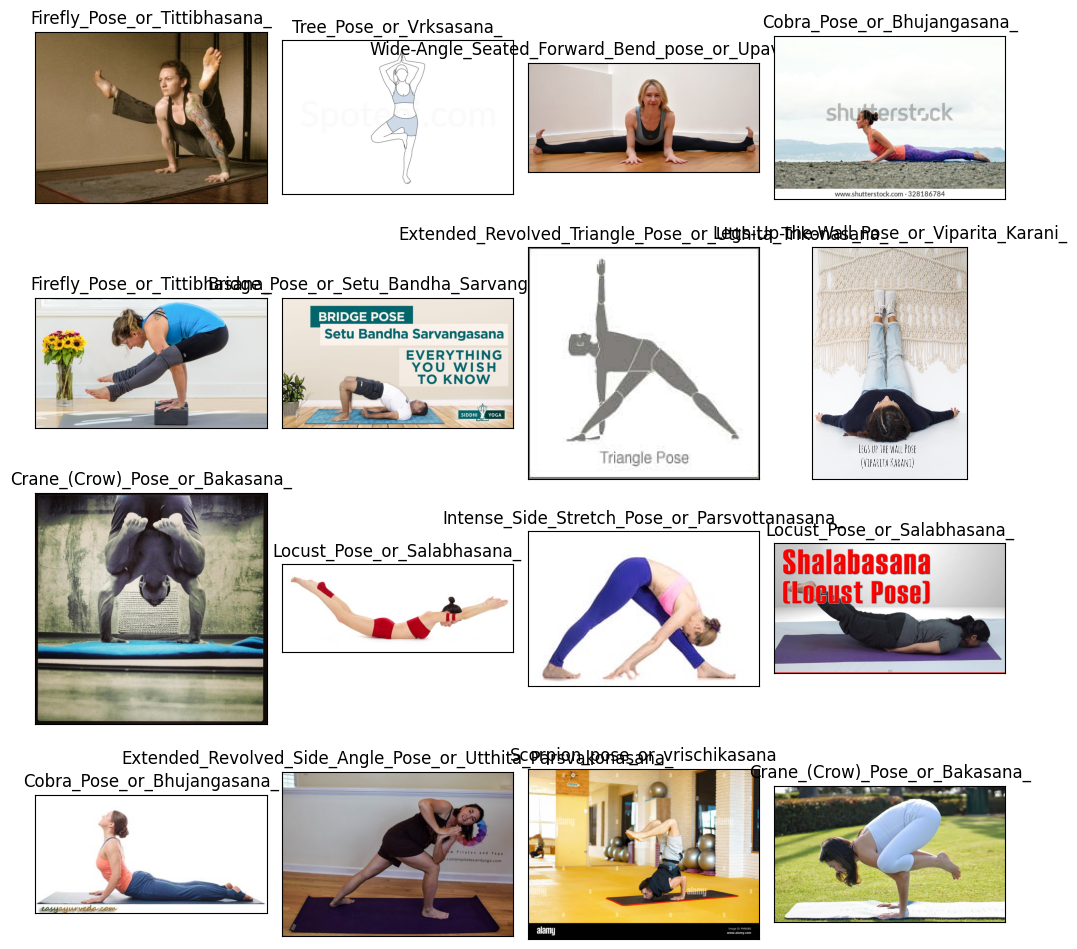

In [5]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

### 1.6 Computing Error Rate Analysis

In [6]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

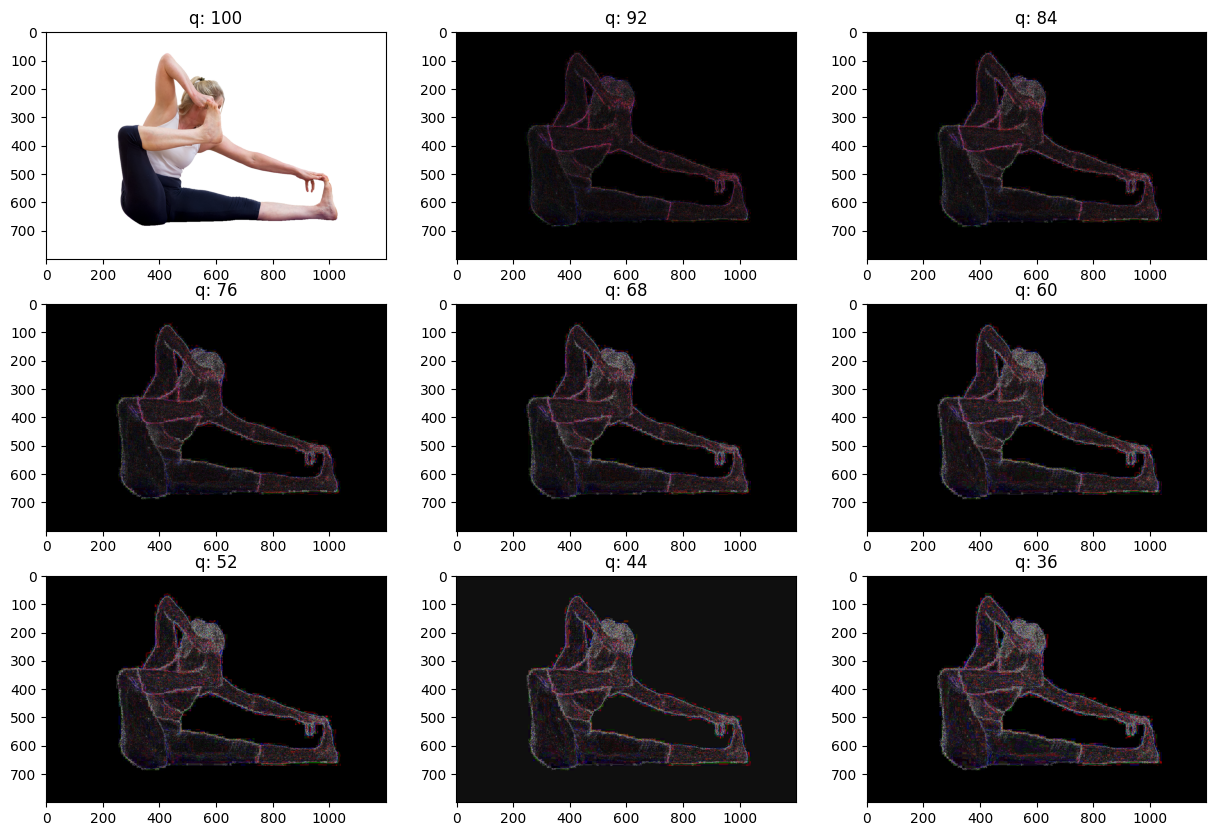

In [7]:
# View random sample from the dataset
p = random_sample('../yoga_dataset_links/Akarna_Dhanurasana')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

### 1.7 Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [8]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

# 加载截断图像的容错设置
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 检查并移除损坏的图像文件，同时更新 DataFrame
def check_images(dataframe, filepath_col='Filepath'):
    valid_files = []
    for filepath in dataframe[filepath_col]:
        if not os.path.exists(filepath):
            print(f"File not found, skipping: {filepath}")
            continue
        try:
            # 使用 with 语句确保文件在检查后关闭
            with Image.open(filepath) as img:
                img.verify()  # 检查图像是否可以正常打开
            valid_files.append(filepath)  # 记录有效文件
        except (IOError, SyntaxError, OSError):
            print(f"Corrupted file detected and removed: {filepath}")
            try:
                os.remove(filepath)  # 删除损坏的文件
            except PermissionError:
                print(f"Could not delete {filepath} as it is being used by another process.")
    
    # 更新 DataFrame，仅保留有效文件
    return dataframe[dataframe[filepath_col].isin(valid_files)].reset_index(drop=True)

# 对训练和测试数据进行检查并更新 DataFrame
train_df = check_images(train_df)
test_df = check_images(test_df)
# 对训练和测试数据进行检查
check_images(train_df)
check_images(test_df)


d:\Anaconda\envs\CVNN\lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Filepath  \
0     ..\yoga_dataset_links\Gate_Pose_or_Parighasana...   
1           ..\yoga_dataset_links\Split pose\2_0_20.jpg   
2     ..\yoga_dataset_links\Standing_big_toe_hold_po...   
3     ..\yoga_dataset_links\Reclining_Hand-to-Big-To...   
4     ..\yoga_dataset_links\Plow_Pose_or_Halasana_\0...   
...                                                 ...   
7435  ..\yoga_dataset_links\Bharadvaja's_Twist_pose_...   
7436  ..\yoga_dataset_links\Bow_Pose_or_Dhanurasana_...   
7437  ..\yoga_dataset_links\Supta_Virasana_Vajrasana...   
7438  ..\yoga_dataset_links\Firefly_Pose_or_Tittibha...   
7439  ..\yoga_dataset_links\Eagle_Pose_or_Garudasana...   

                                                  Label  
0                             Gate_Pose_or_Parighasana_  
1                                            Split pose  
2     Standing_big_toe_hold_pose_or_Utthita_Padangus...  
3     Reclining_Hand-to-Big-Toe_Pose_or_Supta_Padang...  
4                                Plow_Pose_or_Halasana_  
...                                                 ...  
7435       Bharadvaja's_Twist_pose_or_Bharadvajasana_I_  
7436                           Bow_Pose_or_Dhanurasana_  
7437                           Supta_Virasana_Vajrasana  
7438                      Firefly_Pose_or_Tittibhasana_  
7439                          Eagle_Pose_or_Garudasana_  

[7440 rows x 2 columns]

In [9]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [10]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 23808 validated image filenames belonging to 82 classes.
Found 5952 validated image filenames belonging to 82 classes.
Found 7440 validated image filenames belonging to 82 classes.


In [19]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

### 1.8 Training setting
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 82



In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# pretrained_model.trainable = False

pretrained_model.trainable = True
for layer in pretrained_model.layers[:100]: 
    layer.trainable = False

12683000/12683000 [==============================] - 1s 0us/step


In [22]:
# Create checkpoint callback
checkpoint_path = "yoga_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)


In [23]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

### 1.9 Train the model

In [24]:
# 检查 GPU 是否可用
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU:", tf.config.list_physical_devices('GPU')[0])
else:
    print("No GPU detected, using CPU instead.")


inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)


x = pretrained_model(x, training=True)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)



outputs = Dense(82, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

Num GPUs Available:  1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Saving TensorBoard log files to: training_logs/yoga_classification/20241112-185847


C:\Users\Anderson\.conda\envs\COMP9444proj\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/100
103/372 [=======>......................] - ETA: 1:21 - loss: 4.3895 - accuracy: 0.0288

C:\Users\Anderson\.conda\envs\COMP9444proj\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


372/372 [==============================] - 146s 373ms/step - loss: 4.3288 - accuracy: 0.0366 - val_loss: 4.2310 - val_accuracy: 0.0521
Epoch 2/100
372/372 [==============================] - 135s 363ms/step - loss: 4.1874 - accuracy: 0.0604 - val_loss: 3.9854 - val_accuracy: 0.1005
Epoch 3/100
372/372 [==============================] - 134s 359ms/step - loss: 3.9492 - accuracy: 0.0964 - val_loss: 3.6669 - val_accuracy: 0.1603
Epoch 4/100
372/372 [==============================] - 134s 360ms/step - loss: 3.6807 - accuracy: 0.1403 - val_loss: 3.3751 - val_accuracy: 0.2004
Epoch 5/100
372/372 [==============================] - 134s 359ms/step - loss: 3.4677 - accuracy: 0.1793 - val_loss: 3.1730 - val_accuracy: 0.2455
Epoch 6/100
372/372 [==============================] - 135s 363ms/step - loss: 3.2824 - accuracy: 0.2137 - val_loss: 2.9764 - val_accuracy: 0.2799
Epoch 7/100
372/372 [==============================] - 134s 360ms/step - loss: 3.1051 - accuracy: 0.2463 - val_loss: 2.8324 - val_

### 1.10 Model Evaluation
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3> 
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4> <center>$P=TP/(TP+FP)$</center></h4> 

<h3>Recall(R): </h3> 
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>
<h4><center>$R=TP/(TP+FN)$</center></h4>

<h3>F1 score(F1): </h3>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>
<h4><center>$F1=2 * (TP * FP)/(TP+FP)$</center></h4>


In [20]:
# Load the model
model1 = tf.keras.models.load_model("yoga_classification_complete_model.h5")
print("load complete")

results = model1.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

load complete
    Test Loss: 1.12678
Test Accuracy: 72.66%


### 1.11 Visualizing loss curves

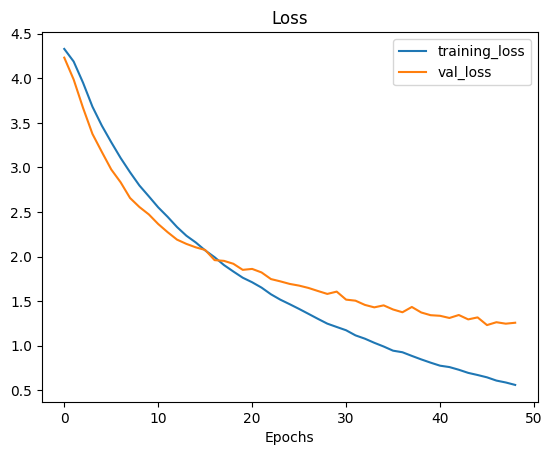

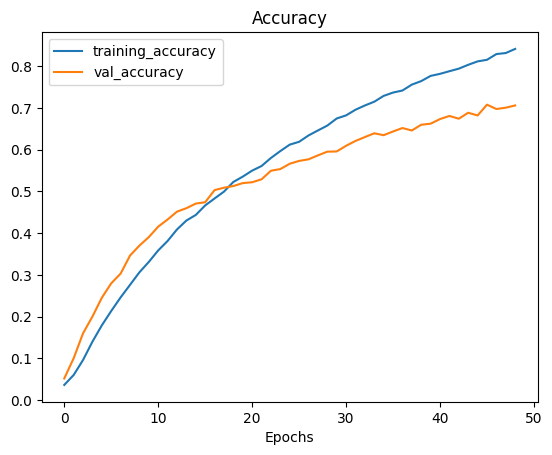

In [26]:
plot_loss_curves(history)

### 1.12 Making predictions on the test data

In [21]:
# Predict the label of the test_images
pred = model1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Gate_Pose_or_Parighasana_', 'Split pose', 'Standing_big_toe_hold_pose_or_Utthita_Padangusthasana', 'Legs-Up-the-Wall_Pose_or_Viparita_Karani_', 'Plow_Pose_or_Halasana_']


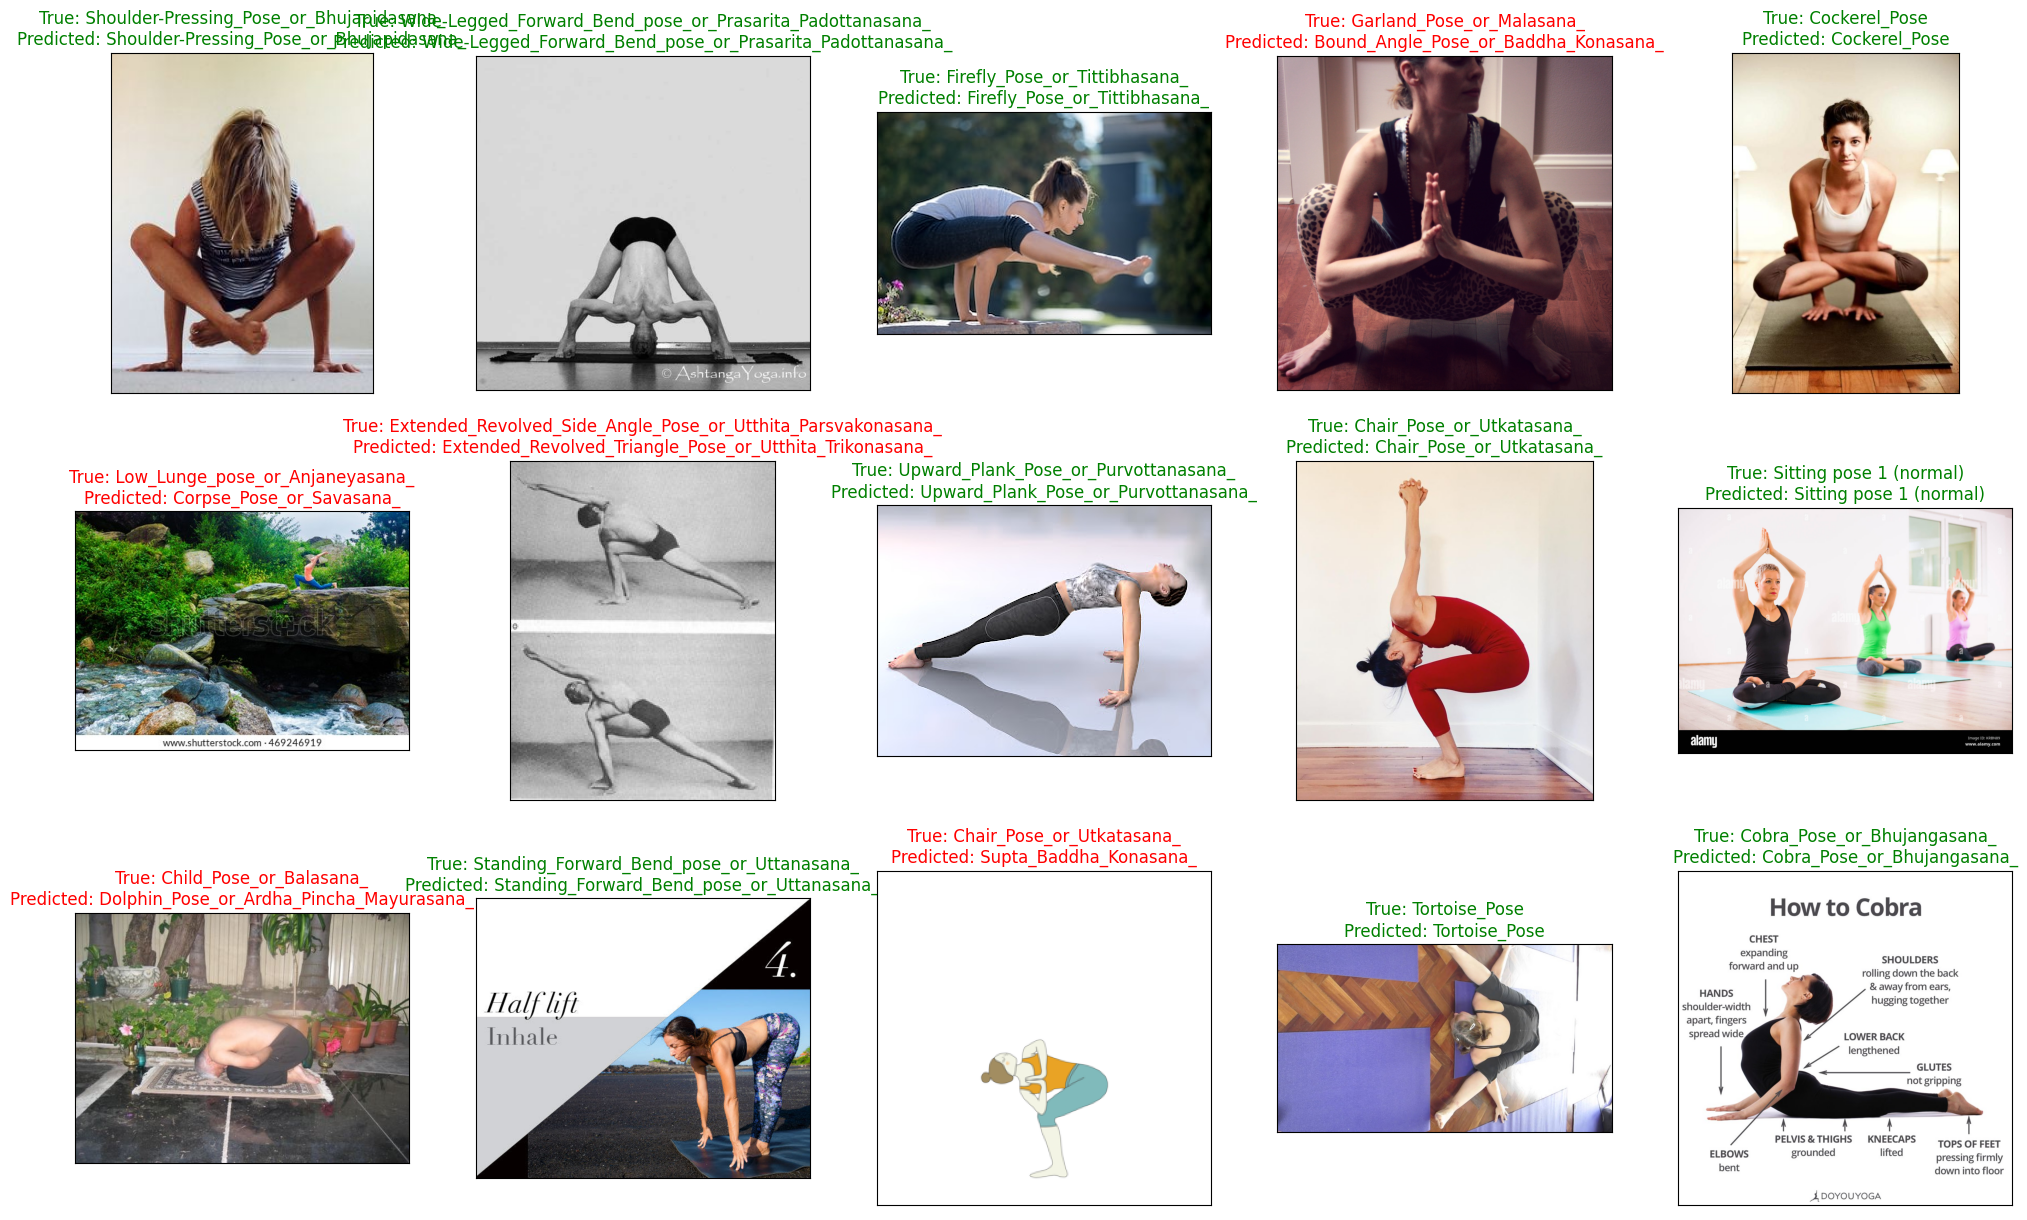

<Figure size 640x480 with 0 Axes>

In [28]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

### 1.13 Plotting the classification reports and confusion matrix

In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

                                                                           precision    recall  f1-score   support

                                                       Akarna_Dhanurasana       0.54      0.69      0.61        39
                             Bharadvaja's_Twist_pose_or_Bharadvajasana_I_       0.62      0.14      0.23        36
                                         Boat_Pose_or_Paripurna_Navasana_       0.72      0.75      0.73       161
                                     Bound_Angle_Pose_or_Baddha_Konasana_       0.69      0.59      0.64        91
                                                 Bow_Pose_or_Dhanurasana_       0.77      0.81      0.79        81
                                 Bridge_Pose_or_Setu_Bandha_Sarvangasana_       0.82      0.68      0.74       103
                                                 Camel_Pose_or_Ustrasana_       0.78      0.84      0.81       129
                                            Cat_Cow_Pose_or_Marjaryasana_      

precision    recall  \
Akarna_Dhanurasana                                0.540000  0.692308   
Bharadvaja's_Twist_pose_or_Bharadvajasana_I_      0.625000  0.138889   
Boat_Pose_or_Paripurna_Navasana_                  0.715976  0.751553   
Bound_Angle_Pose_or_Baddha_Konasana_              0.692308  0.593407   
Bow_Pose_or_Dhanurasana_                          0.767442  0.814815   
...                                                    ...       ...   
Yogic_sleep_pose                                  0.735294  0.675676   
viparita_virabhadrasana_or_reverse_warrior_pose   0.755556  0.772727   
accuracy                                          0.726613  0.726613   
macro avg                                         0.714261  0.689958   
weighted avg                                      0.731137  0.726613   

                                                 f1-score      support  
Akarna_Dhanurasana                               0.606742    39.000000  
Bharadvaja's_Twist_pose_or_Bharadvajasana_I_     0.227273    36.000000  
Boat_Pose_or_Paripurna_Navasana_                 0.733333   161.000000  
Bound_Angle_Pose_or_Baddha_Konasana_             0.639053    91.000000  
Bow_Pose_or_Dhanurasana_                         0.790419    81.000000  
...                                                   ...          ...  
Yogic_sleep_pose                                 0.704225    37.000000  
viparita_virabhadrasana_or_reverse_warrior_pose  0.764045    44.000000  
accuracy                                         0.726613     0.726613  
macro avg                                        0.693714  7440.000000  
weighted avg                                     0.723729  7440.000000  

[85 rows x 4 columns]

### 1.14 Grad-Cam Visualization

C:\Users\klaus\AppData\Local\Temp\ipykernel_12184\892203968.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
d:\Anaconda\envs\CVNN\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


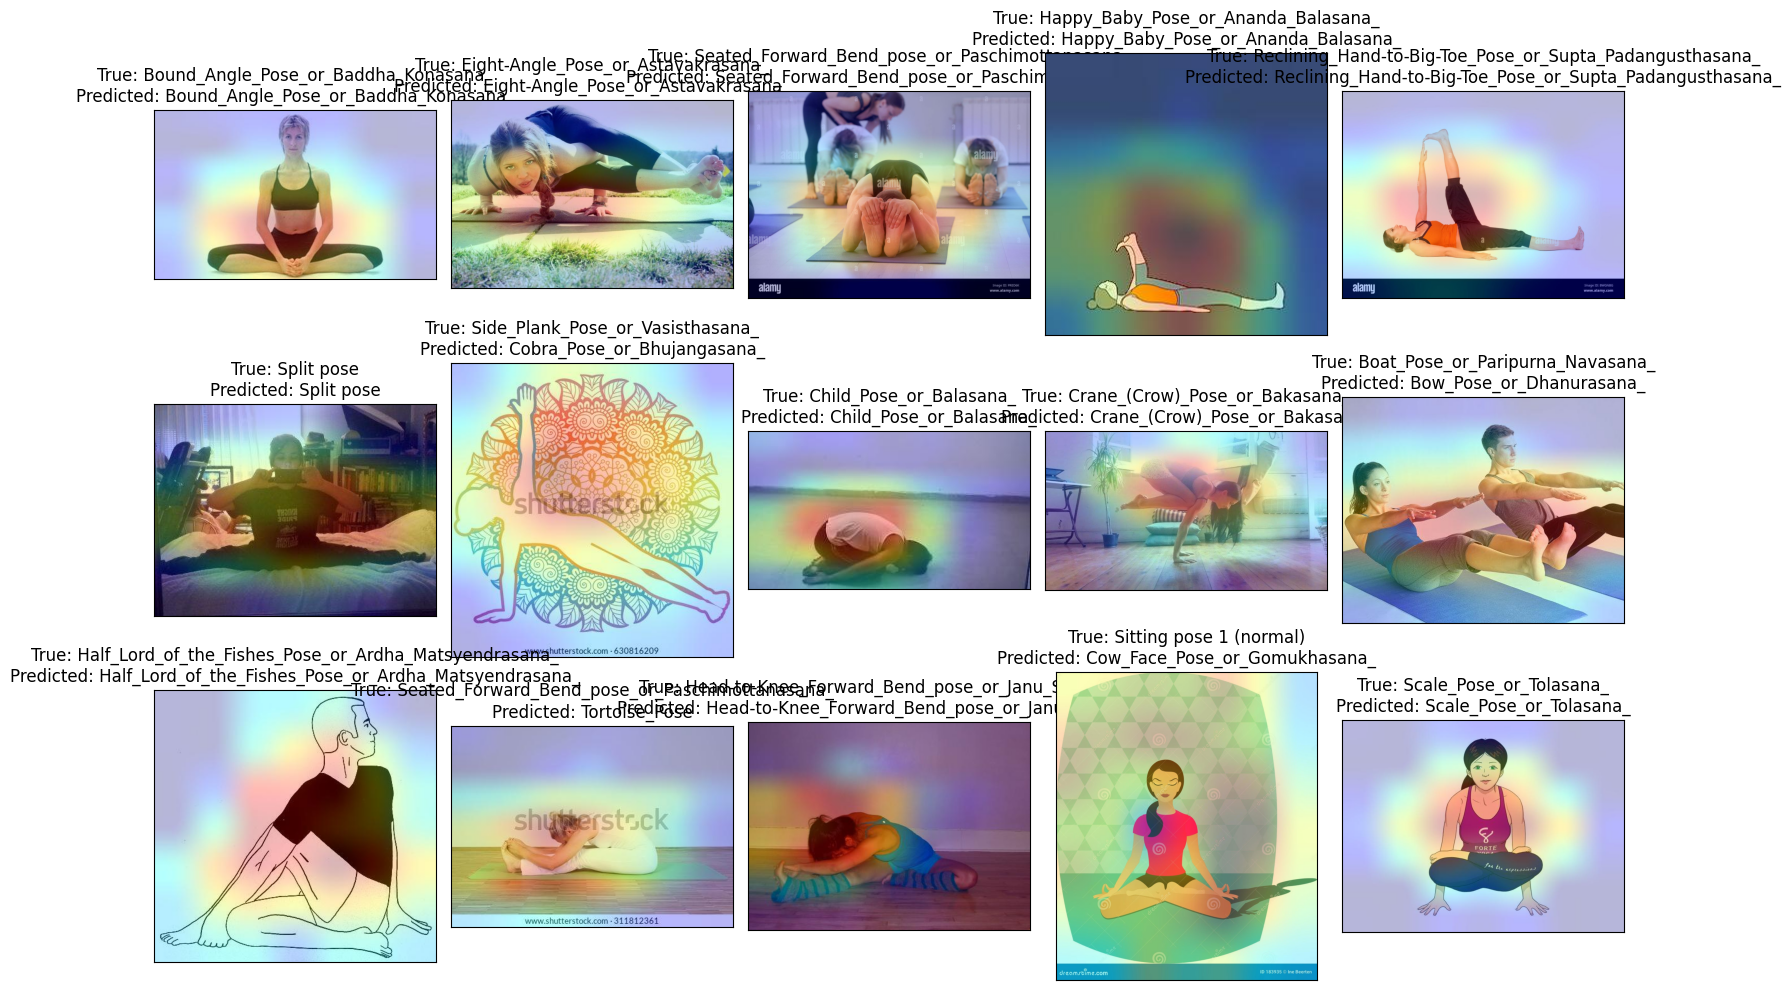

In [23]:
def get_img_array(img_path, size=(224, 224)):
    # Load the image and resize it
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Add a dimension to convert the image into batch size
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last convolutional layer and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Compute the gradient of the class channel with respect to the feature map of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Get the average value of gradients for each feature channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Generate the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Scale the heatmap to the range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use the jet colormap to colorize the heatmap
    jet = cm.get_cmap("jet")

    # Get RGB values
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Convert the colored heatmap to an image
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Overlay the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    # Save and return the overlaid image
    superimposed_img.save(cam_path)
    return cam_path

# Configure preprocessing for the model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Set the name of the last convolutional layer and image size
last_conv_layer_name = "Conv_1"  # Update with the actual last convolutional layer name
img_size = (224, 224)

# Remove the softmax from the last layer
model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=True)
model.layers[-1].activation = None

# Randomly select images from the test dataset and generate Grad-CAM
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
random_index = random.sample(range(len(test_df)), 15)  # Assume test_df is your test dataset DataFrame

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")

plt.tight_layout()
plt.show()